<a href="https://colab.research.google.com/github/f247805/DeepLearning/blob/main/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model


In [10]:
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:

!unzip "/content/drive/MyDrive/archive (3).zip"



In [11]:
BASE_DIR = '/content/utkface_aligned_cropped/UTKFace'

In [12]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/utkface_aligned_cropped/UTKFace/54_1_...,54,1
1,/content/utkface_aligned_cropped/UTKFace/34_1_...,34,1
2,/content/utkface_aligned_cropped/UTKFace/20_1_...,20,1
3,/content/utkface_aligned_cropped/UTKFace/36_0_...,36,0
4,/content/utkface_aligned_cropped/UTKFace/43_0_...,43,0


In [14]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

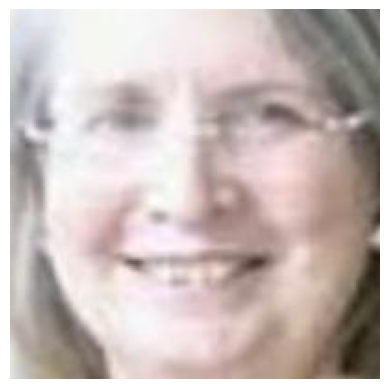

In [15]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

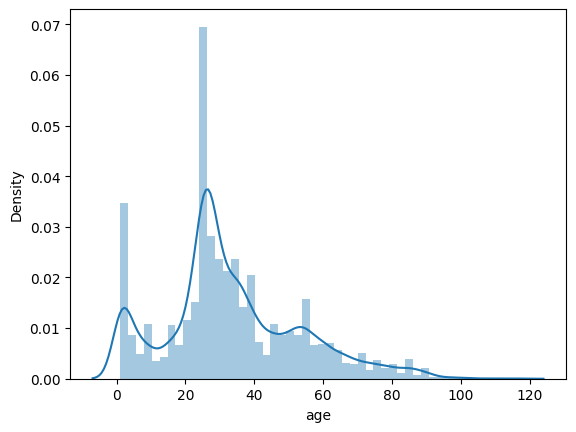

In [16]:
sns.distplot(df['age'])

In [ ]:


sns.countplot(df['gender'])

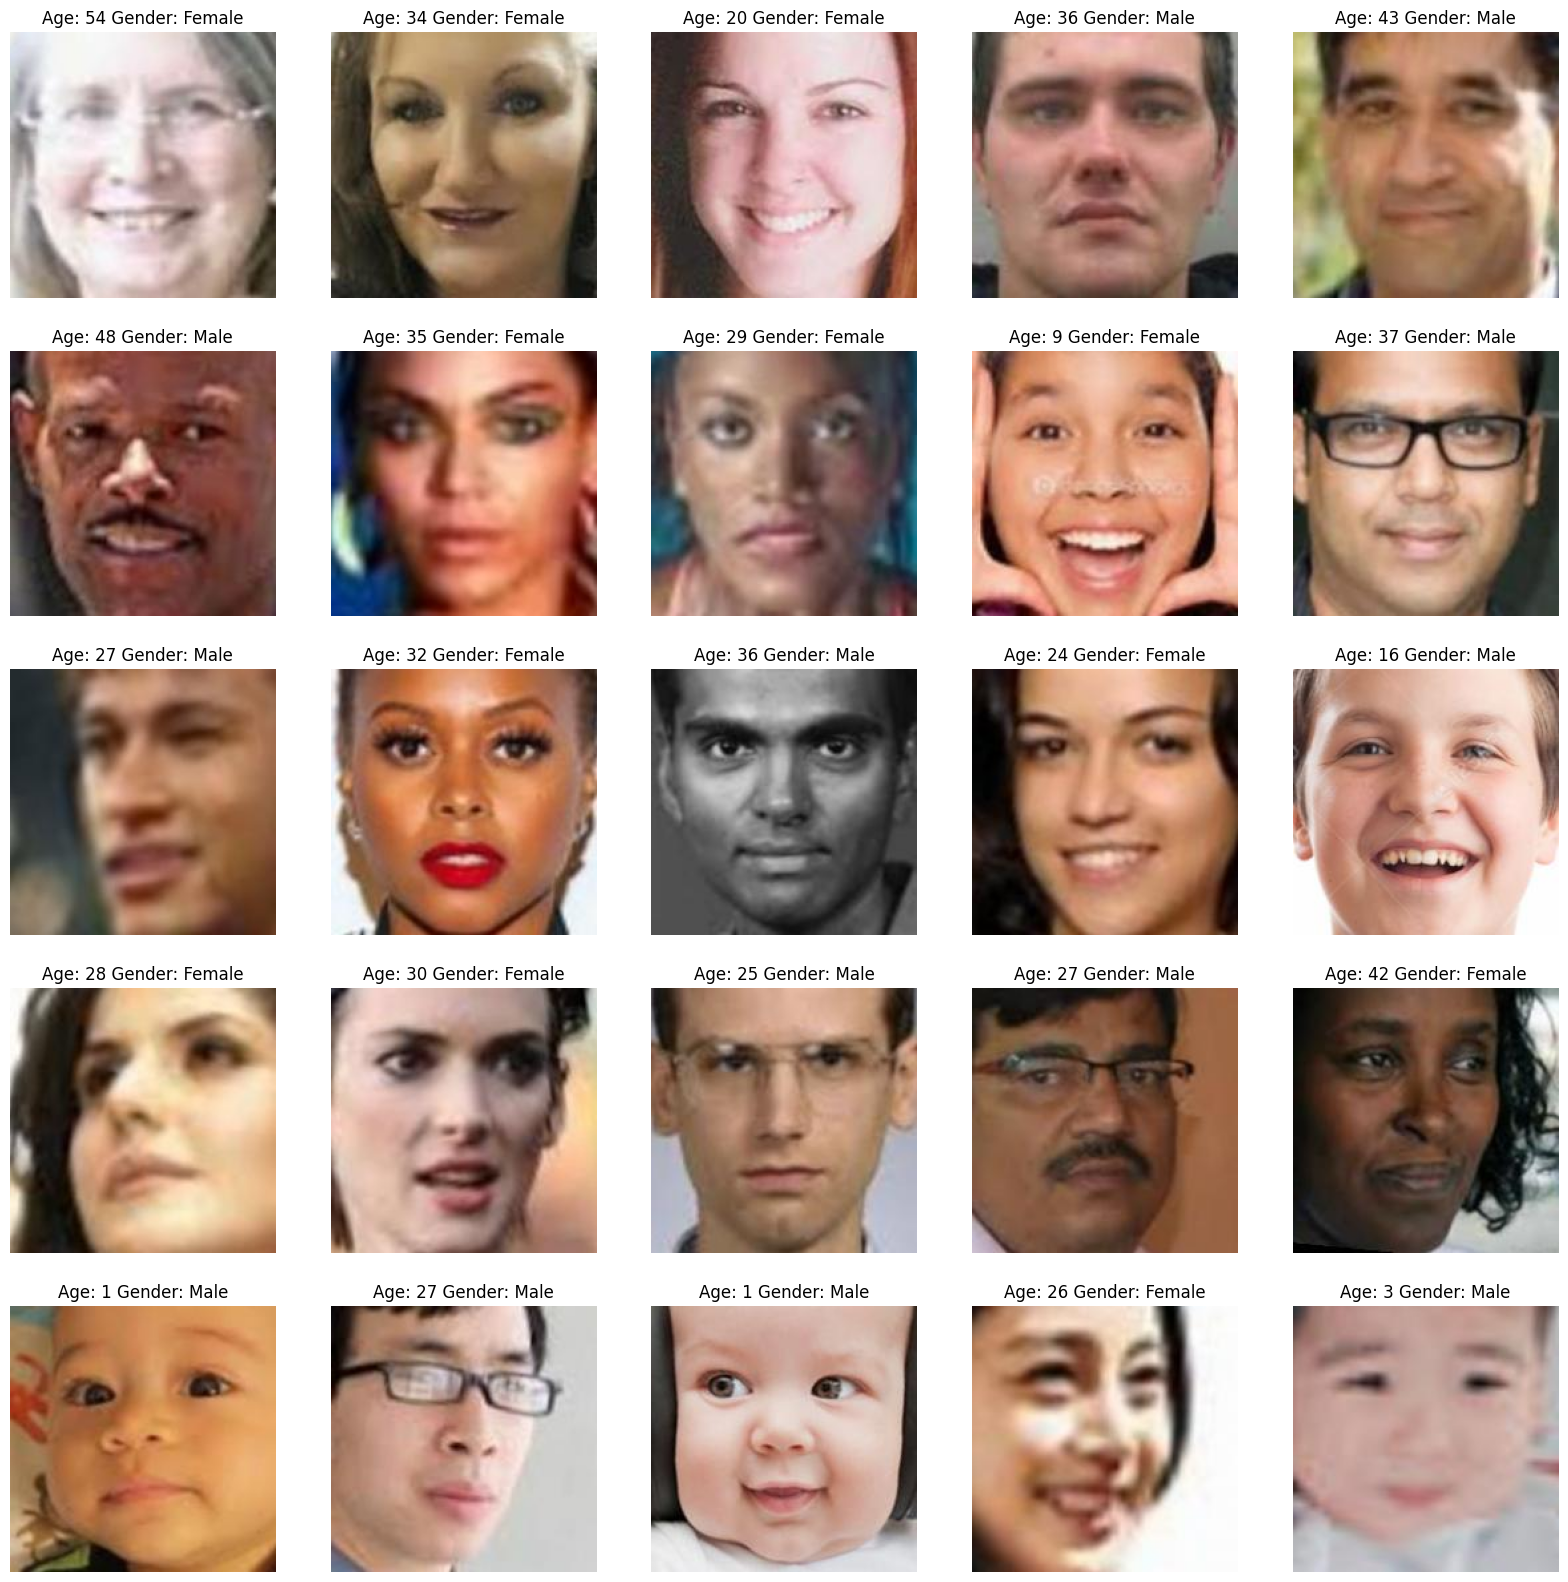

In [18]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [19]:
import numpy as np
from PIL import Image
from tqdm import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')  # Open image in grayscale mode
        img = img.resize((128, 128), Image.ANTIALIAS)  # Resize image
        img = np.array(img)  # Convert image to numpy array
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)  # Reshape features if using as input to a convolutional neural network
    return features


In [20]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:34<00:00, 688.67it/s]


In [21]:
X.shape

(23708, 128, 128, 1)

In [22]:
# normalize the images
X = X/255.0

In [23]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [24]:
input_shape = (128, 128, 1)

In [25]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 736s 1s/step - loss: 14.5138 - gender_out_loss: 0.6289 - age_out_loss: 13.8849 - gender_out_accuracy: 0.6172 - gender_out_mae: 0.4425 - age_out_accuracy: 0.0472 - age_out_mae: 13.8849 - val_loss: 13.1889 - val_gender_out_loss: 0.5553 - val_age_out_loss: 12.6336 - val_gender_out_accuracy: 0.7250 - val_gender_out_mae: 0.3513 - val_age_out_accuracy: 0.0426 - val_age_out_mae: 12.6336
Epoch 2/30
593/593 [==============================] - ETA: 0s - loss: 10.8194 - gender_out_loss: 0.4643 - age_out_loss: 10.3551 - gender_out_accuracy: 0.7787 - gender_out_mae: 0.3078 - age_out_accuracy: 0.0436 - age_out_mae: 10.3551

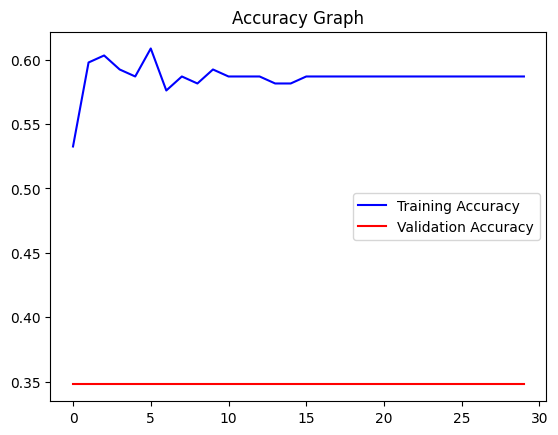

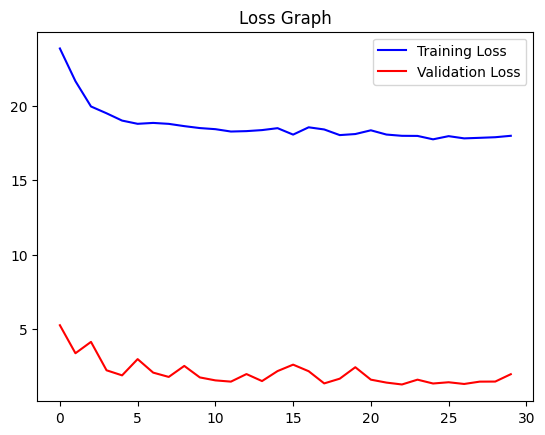

In [ ]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()